## Predicting Tennis Players' Ranking ##

**Introduction**

Tennis, a globally cherished sport, epitomizes elegance, precision, and athleticism. Played on various surfaces like grass, clay, and hard court, tennis involves players rallying a ball back and forth over a net using rackets. One crucial aspect of tennis is the occurrence of double faults and aces. A double fault happens when a player fails to get both serves in bounds, resulting in the loss of a point. Conversely, an ace occurs when a serve is untouched by the opponent, leading to an instant point for the server. In the realm of tennis analytics, understanding the frequency and impact of double faults and aces can offer valuable insights into player performance, strategy, and match outcomes. To explore this, we will analyze a comprehensive dataset comprising match statistics, including serve performance, from various professional tennis tournaments. This analysis aims to uncover patterns and correlations between double faults, aces, and match results, ultimately shedding light on the significance of serving proficiency and its relationship to player rank. We will also ask if a paticular tennis player's rank, can be predicted by the number of aces and double faults they make per game.

**Preliminary Exploratory Data Analysis**

We downloaded and read the dataset titled “Game results for Top 500 Players from 2017-2019” from the website. After limiting the dates to the year 2019 by filtering, we selected the columns of interest, specifically, the player’s ID, ace, double faults, and the ranks of both winners and losers, respectively. We then merged the corresponding wi
nner and loser columns for each attribute, resulting in a simplified data frame consisting of 4 columns: ID, ace, df(double faults), and rank. Therefore, each row in this frame represents a single observation. Finally, we split the data into training and testing sets, allocating a 0.75 proportion to the training set.
After summarizing the training data, we found that the average number of aces was 6.655, and it was 3.604 for double faults. In addition, we identified the missing data, with 84 cases in the ace column, 84 in the double faults column, and 5 in the rank column.

**Reading the Data**

In [1]:
# load packages
library(tidyverse)
library(tidymodels)
library(repr)
# read the data 
# note: The code below will download the data into the current working directory and read it
url <- "https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn"
download.file(url, "./atp2017-2019.csv")
player_result <- read_csv("./atp2017-2019.csv")
glimpse(player_result)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Rows: 6,866
Columns: 50
$ ...1               <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…
$ tourney_id         <chr> "2019-M020", "2019-M020", "2019-M020", "2019-M020",…
$ tourney_name       <chr> "Brisbane", "Brisbane", "Brisbane", "Brisbane", "Br…
$ surface            <chr> "Hard", "Hard", "Hard", "Hard", "Hard", "Hard", "Ha…
$ draw_size          <dbl> 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,…
$ tourney_level      <chr> "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "…
$ tourney_date       <dbl> 20181231, 20181231, 20181231, 20181231, 20181231, 2…
$ match_num          <dbl> 300, 299, 298, 297, 296, 295, 294, 293, 292, 291, 2…
$ winner_id          <dbl> 105453, 106421, 105453, 104542, 106421, 104871, 105…
$ winner_seed        <chr> "2", "4", "2", NA, "4", NA, "2", NA, "7", "4", "5",…
$ winner_entry       <chr> NA, NA, NA, "PR", NA, NA, NA, "PR", NA, NA, NA, NA,…
$ winner_name        <chr> "Kei Nishikori", "Daniil Medvedev", "Kei Nishikori"…
$ winner_hand   

**Cleaning and Wrangling the Data**

In [2]:
# filter year 2019, there is indeed a more formal way with more steps to do that,
# but we can simply do it this way with only one step because we don't need the
# year information later on
player_2019 <- filter(player_result, tourney_date <= 20199999
                       , tourney_date >=20190000) |>
  select(winner_id, loser_id, w_ace, l_ace, w_df, l_df, winner_rank, loser_rank)

# seperate the original data into winner and loser
player_winner <- player_2019 |>
  select(winner_id, w_ace, w_df, winner_rank) |>
  rename(id = winner_id, ace = w_ace, df = w_df, rank = winner_rank)
player_loser <- player_2019 |>
  select(loser_id, l_ace, l_df, loser_rank) |>
  rename(id = loser_id, ace = l_ace, df=l_df, rank = loser_rank)

# Combine them together by rows to form a data into a tidy format
player_clean <- bind_rows(player_winner, player_loser)
head(player_clean)

id,ace,df,rank
<dbl>,<dbl>,<dbl>,<dbl>
105815,7,2,63
111815,17,5,93
105815,9,0,63
111815,11,0,93
105526,22,3,58
105815,11,1,63


In [3]:
# Split data into training data and testing data
player_split <- player_clean |>
  initial_split(prop = 0.75, strata = rank)
player_training <- training(player_split)
player_testing <- testing(player_split)
head(player_training)

id,ace,df,rank
<dbl>,<dbl>,<dbl>,<dbl>
104926,5,4,13
126774,8,1,15
106043,1,3,19
104925,6,2,1
105676,9,3,22
104926,12,3,13


**Summarizing the Data**

In [4]:
# Exploratory data analysis to training data
Summarised_training <- player_training |>
  summarize(ace_mean = mean(ace, na.rm = TRUE),
            df_mean = mean(df, na.rm = TRUE),
            missing_id = sum(is.na(id)), 
            missing_ace = sum(is.na(ace)),
            missing_df = sum(is.na(df)),
            missing_rank = sum(is.na(rank)))
Summarised_training

ace_mean,df_mean,missing_id,missing_ace,missing_df,missing_rank
<dbl>,<dbl>,<int>,<int>,<int>,<int>
6.663477,3.060416,0,73,73,5


**Visualizing the Data**

Warning message:
“Removed 73 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 73 rows containing non-finite values (`stat_bin()`).”


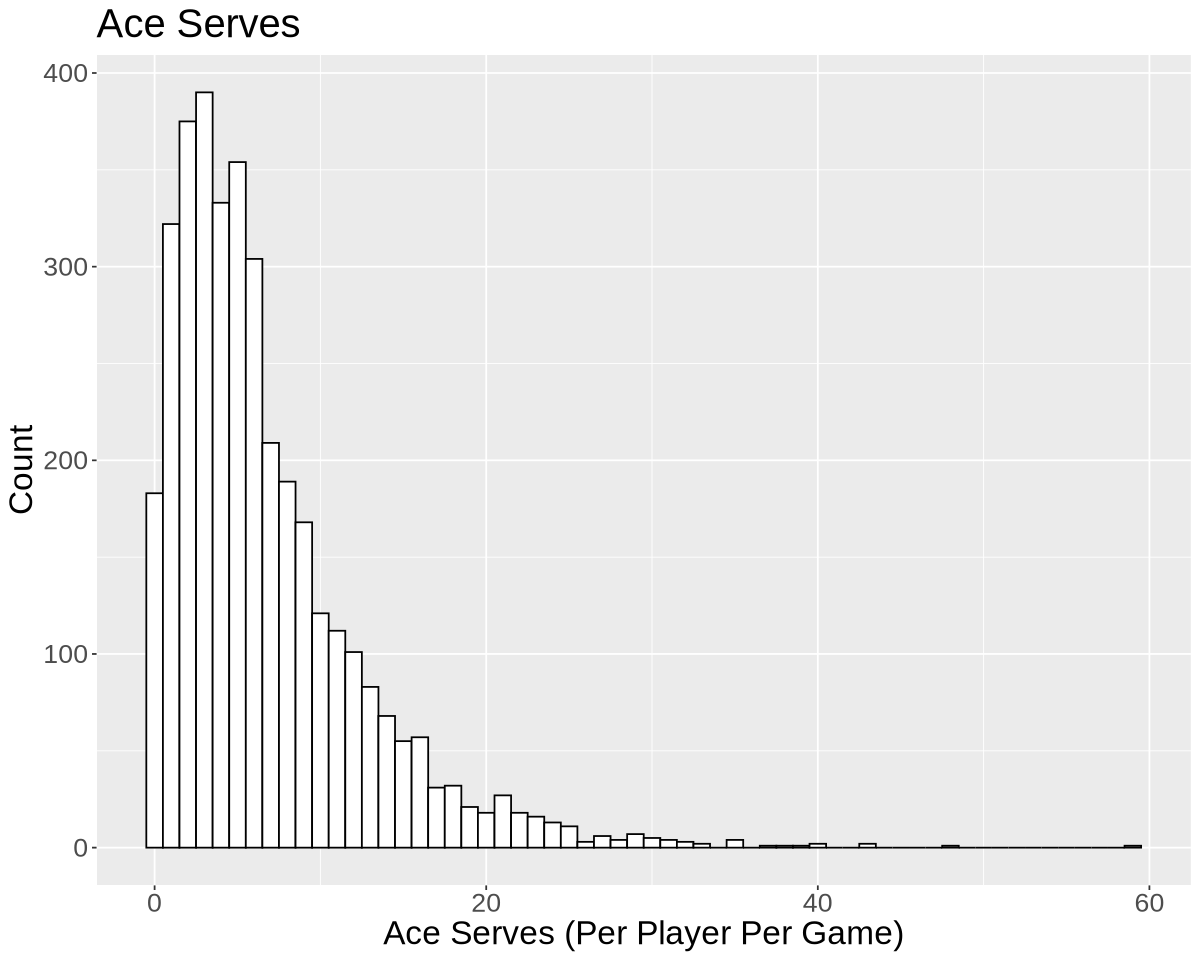

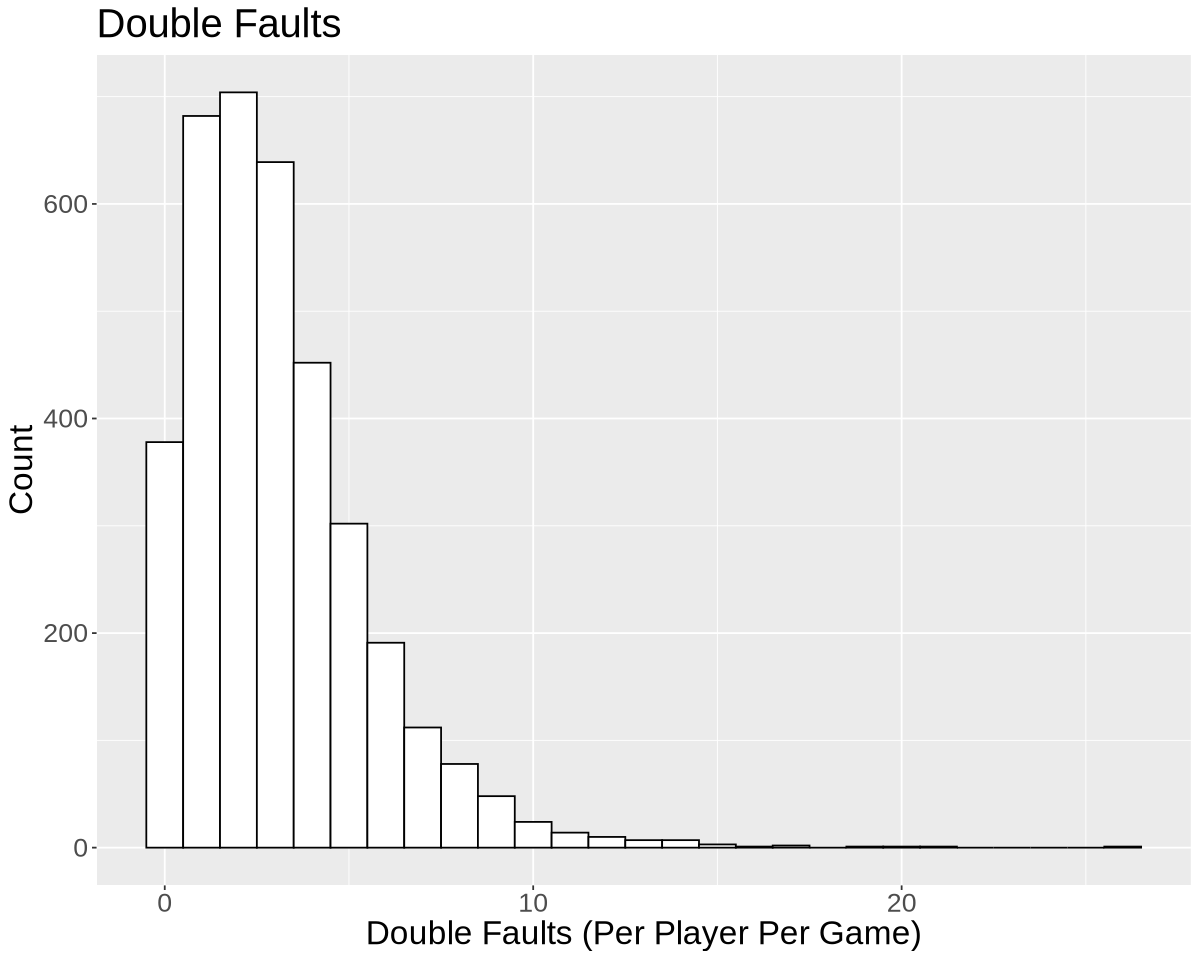

In [6]:
options(repr.plot.width = 10, repr.plot.height = 8) 

ace_plot<-ggplot(player_training, aes(x=ace))+
    geom_histogram(binwidth=1, colour="black", fill="white") +
    xlab("Ace Serves (Per Player Per Game)") +
    ylab("Count") +
    ggtitle("Ace Serves") +
    theme(text = element_text(size=20))

df_plot<-ggplot(player_training, aes(x=df))+
    geom_histogram(binwidth=1, colour="black", fill="white") +
    xlab("Double Faults (Per Player Per Game)") +
    ylab("Count") +
    ggtitle("Double Faults")+
    theme(text = element_text(size=20))

ace_plot
df_plot

**Methods**

We will develop a regression model using a player’s number of aces and double faults to predict their rank. Therefore, ace and double faults will serve as the predictor variables, and rank will be the response variable. Since it is difficult to visualize the results in 3D due to two predictor variables, instead, we will plot a regression model with a regression line in 2D for the rank variable against each predictor variable respectively. 


**Expected Outcomes and Significance**

In this project, we expect to predict that the number in a player's rank generally decreases (rank is higher) as the number of ace increases while holding the double faults constant, and the number in rank generally increases (rank is lower) as the number of double faults increases while holding the ace constant. In addition, we predict that the regression model with these two predictor variables will exhibit higher estimated accuracy, recall, and precision, and a lower estimated standard deviation compared to models that use either predictor variable alone. The outcome of this data will allow players to get a sense of where they rank based on how many ace serves and double faults they have done throughout a game. Furthermore, some questions this project could lead to is: “What other factors are there to determine where a player ranks?”,  “Can we estimate a player's ranking based on the ratio of double fault to ace serve?”, and “Will the type of serve be important in the tournament as a whole?” 

**Bibliography**


What is an Ace and Double fault in Tennis. (2010, July 1). Something about Everything. https://whyentrepreneurs.wordpress.com/2010/07/01/what-is-an-ace-and-double-fault-in-tennis/